In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, linregress
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import r2_score
from pingouin import ancova
from sklearn.manifold import MDS
from sklearn.metrics import DistanceMetric
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import f
from itertools import permutations
import warnings
warnings.filterwarnings('ignore')
from umap import umap_ as UMAP
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.metrics import pairwise_distances
import itertools

# Data loading and cleaning

In [2]:
df = pd.read_excel('FINAL DRY + DRAINAGE PLANT COMMUNITIES MAIN MATRIX WTMW.xlsx')
df.shape

(102, 34)

In [3]:
geo_df = pd.read_excel('Channel morphology.xls').loc[:52]
geo_df.shape

(53, 15)

In [4]:
geo_merge = geo_df[['Site #', 'Geomorphic surface']]
geo_merge.head()

,Site #,Geomorphic surface
0,0.0,1
1,1.0,1
2,2.0,1
3,3.0,1
4,4.0,1


In [5]:
df.columns = df.iloc[2]
df = df[3:].reset_index(drop = True)
df.rename(columns = {np.nan : 'site'}, inplace = True)

In [6]:
upland_index = df[df.site.str.contains('d')].index
df['uplands'] = 0
df.loc[upland_index, 'uplands'] = 1

In [7]:
df.uplands.value_counts()

uplands
0    53
1    46
Name: count, dtype: int64

In [8]:
df.site = df.site.str.replace('d', '').astype(int)

In [9]:
df['site'] = df.site.astype(int)

In [10]:
df = df.astype(float)

In [11]:
tdf = df.merge(geo_merge, left_on = 'site', right_on = 'Site #', how = 'left')
tdf.shape

(99, 37)

In [12]:
tdf['Geomorphic surface'].value_counts()

Geomorphic surface
2    52
1    24
3    13
4    10
Name: count, dtype: int64

In [13]:
tdf.rename(columns=lambda x: x.strip(), inplace=True)

In [14]:
tdf['richness'] = tdf.drop(columns = ['site', 'uplands', 'Site #', 'Geomorphic surface']).apply(lambda x: (x != 0).sum(), axis = 1)

In [15]:
tdf['distance'] = tdf.site * 0.25

In [16]:
tdf.max().sort_values().head(15)

T.amer                 0.4
Sphear                 0.8
Steph                  0.8
Buckwhe                0.8
grass                  0.8
uplands                1.0
O.engl                 3.1
E.engle                3.2
F.cyl                  3.2
Geomorphic surface       4
H.mono                 6.3
A.dum                  6.4
S.mex                  6.4
K.grey                12.8
O.big                 12.8
dtype: object

In [17]:
tdf.drop(columns = ['T.amer', 'Buckwhe', 'grass', 'Sphear', 'Steph', 'O.engl', 'F.cyl', 'E.engle', 'Site #'], inplace = True)

In [18]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   site                99 non-null     float64
 1   P.micro             99 non-null     float64
 2   B.jun               99 non-null     float64
 3   A.greg              99 non-null     float64
 4   S.mex               99 non-null     float64
 5   Lycium2             99 non-null     float64
 6   Lycium1             99 non-null     float64
 7   S.chin              99 non-null     float64
 8   E.far               99 non-null     float64
 9   A.delt              99 non-null     float64
 10  L.tri               99 non-null     float64
 11  E.tri               99 non-null     float64
 12  H.emory             99 non-null     float64
 13  A.oides             99 non-null     float64
 14  K.grey              99 non-null     float64
 15  F.splen             99 non-null     float64
 16  C.gig     

# Data exploration

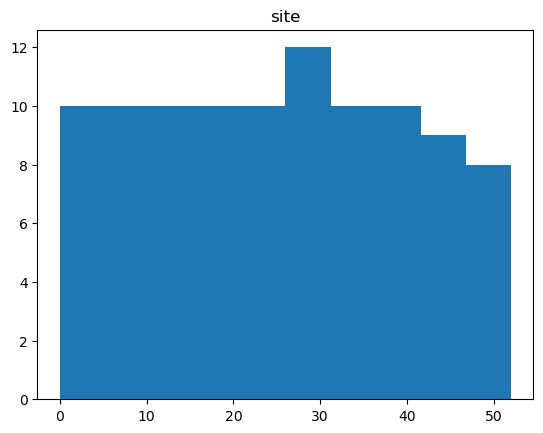

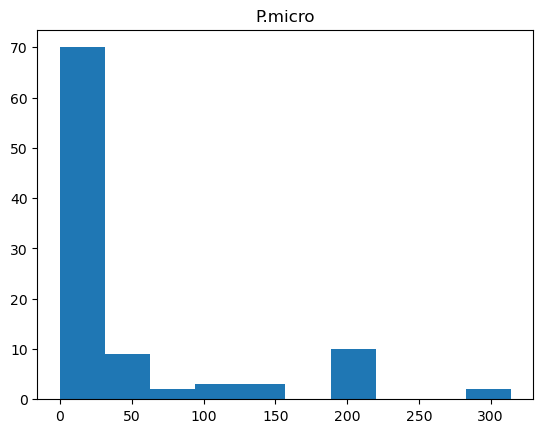

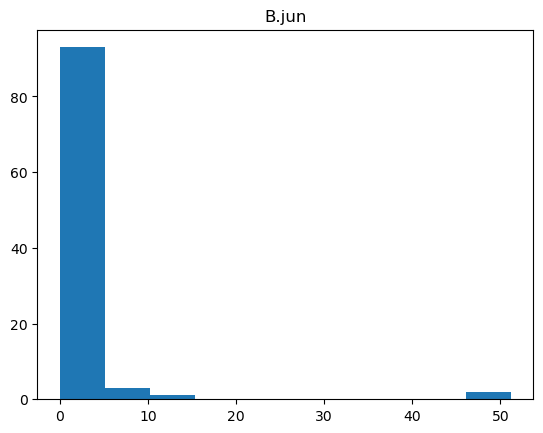

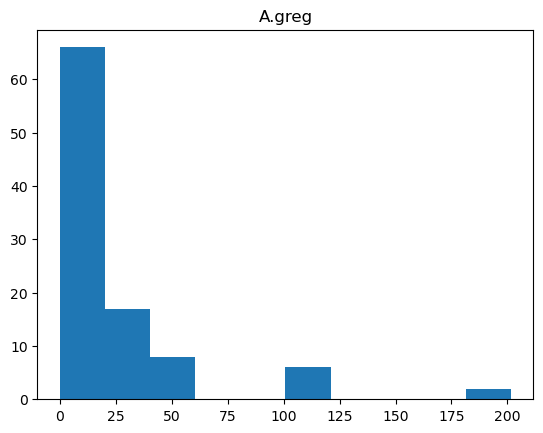

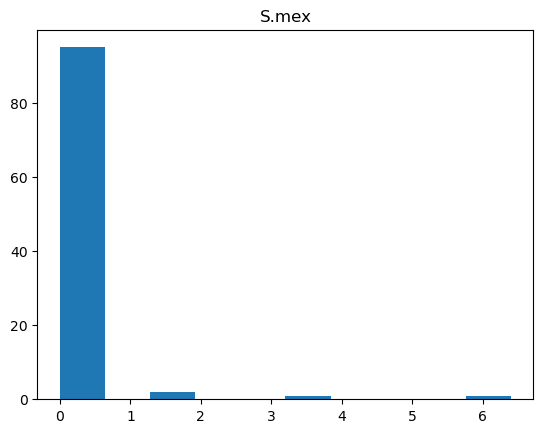

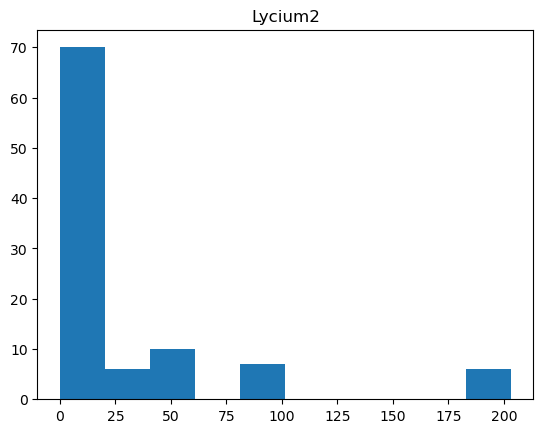

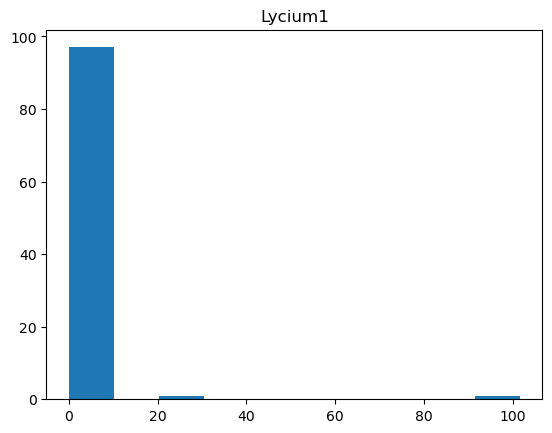

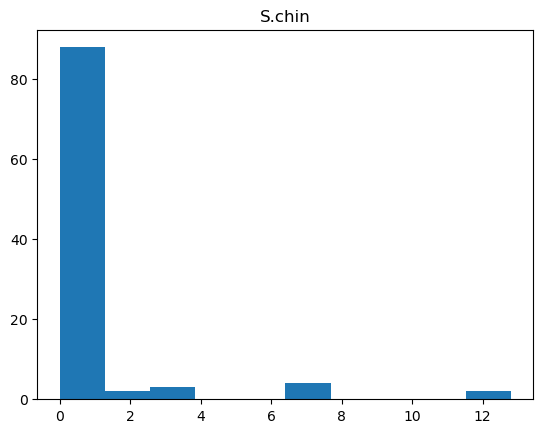

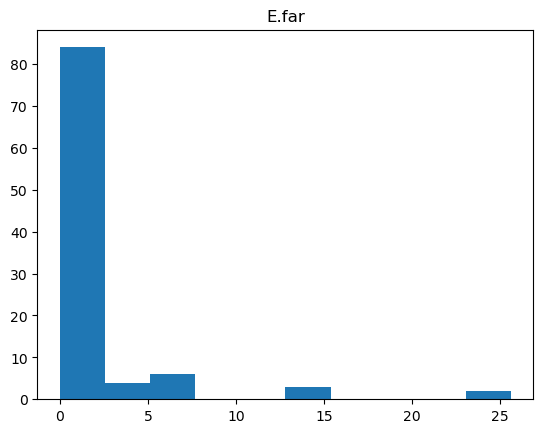

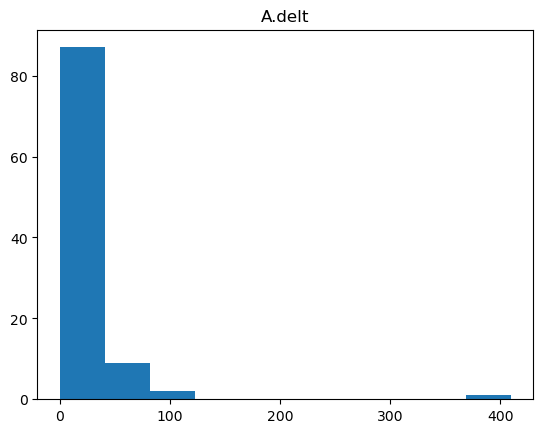

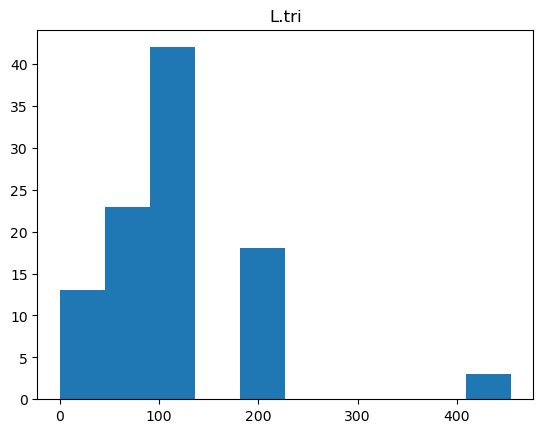

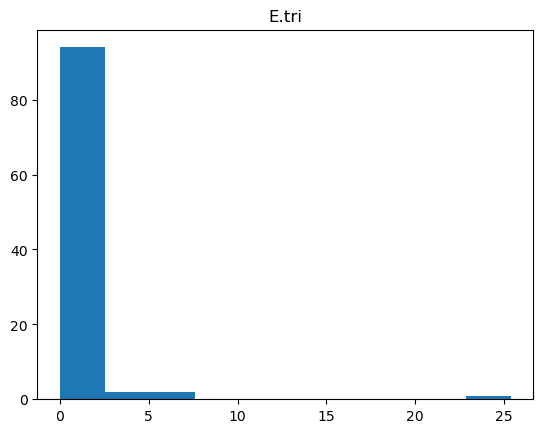

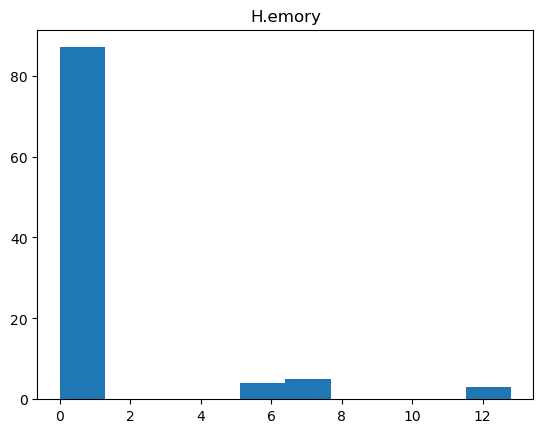

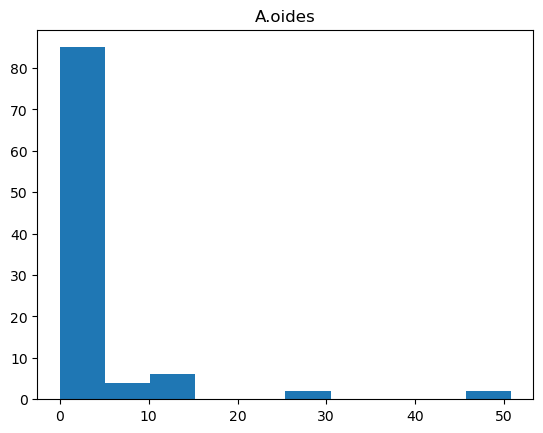

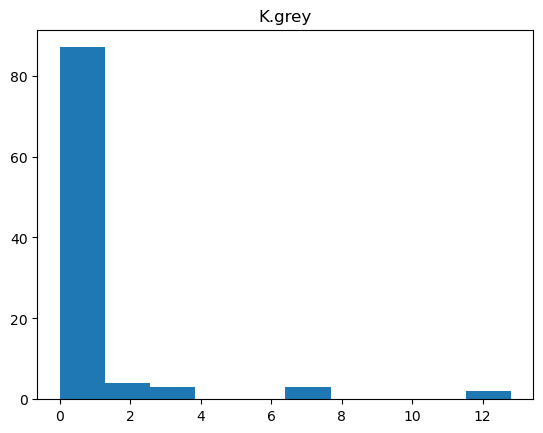

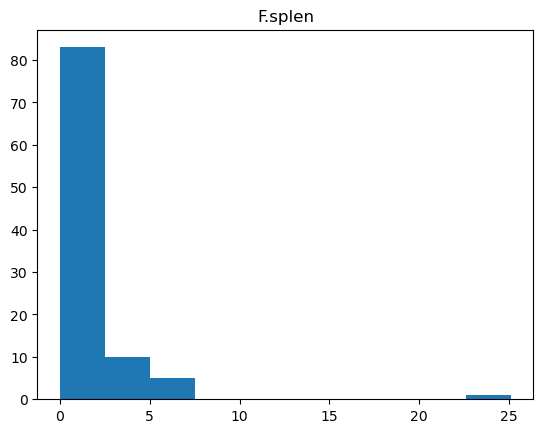

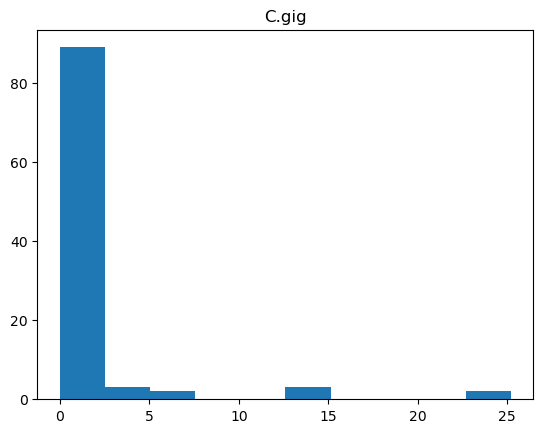

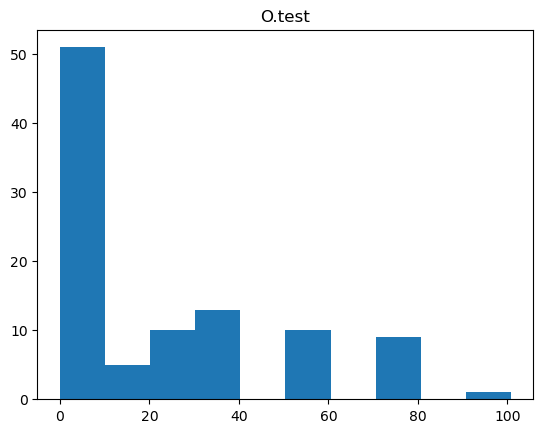

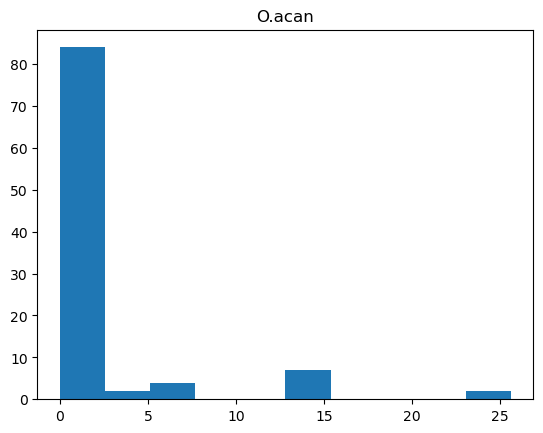

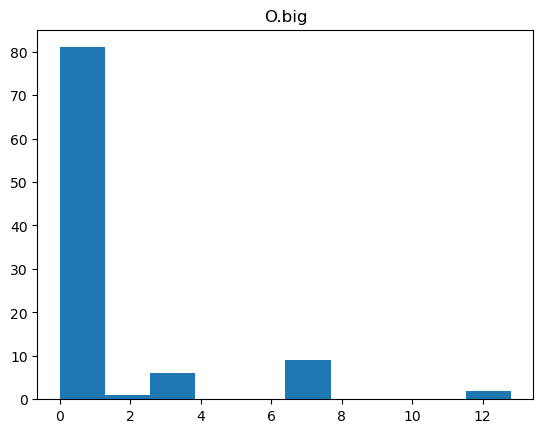

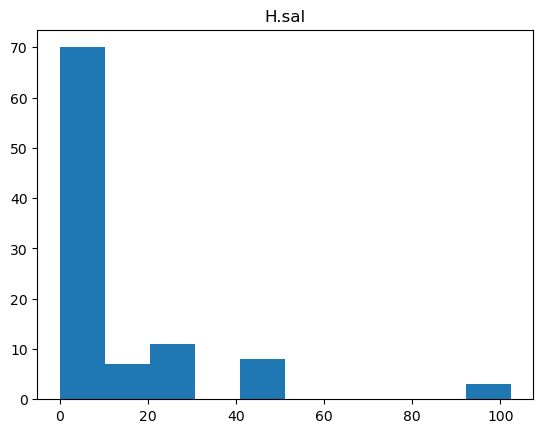

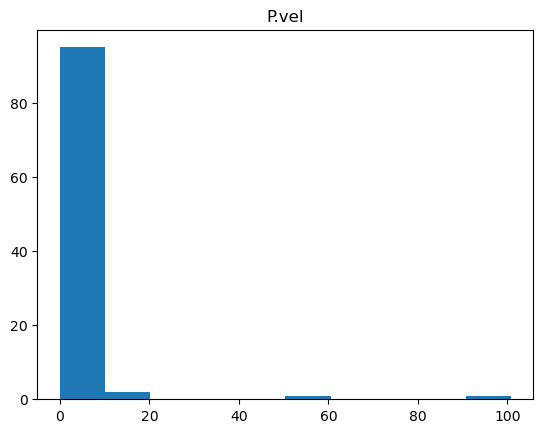

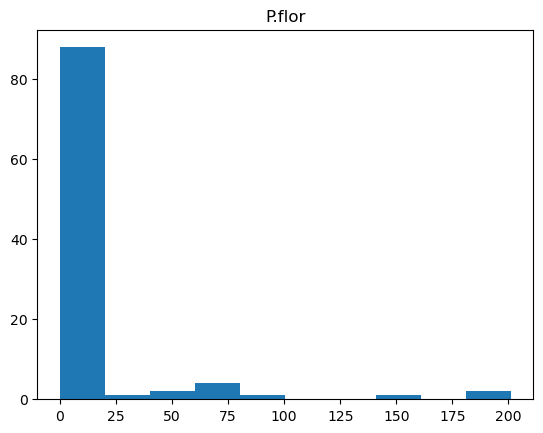

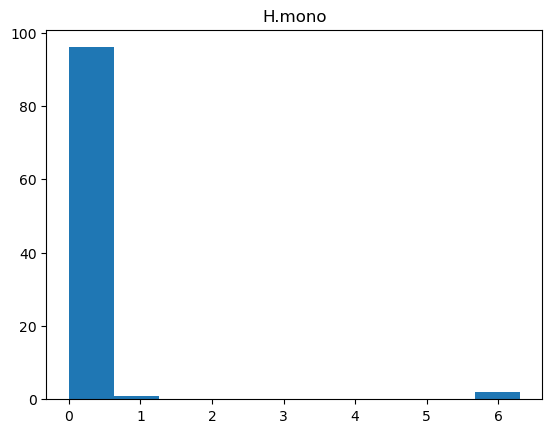

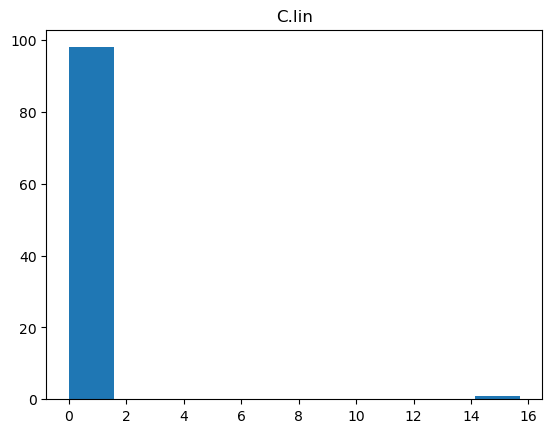

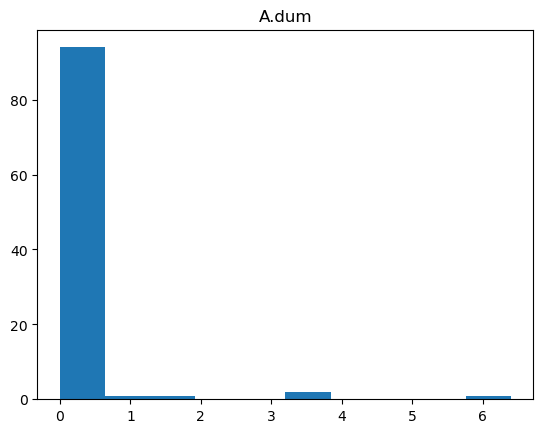

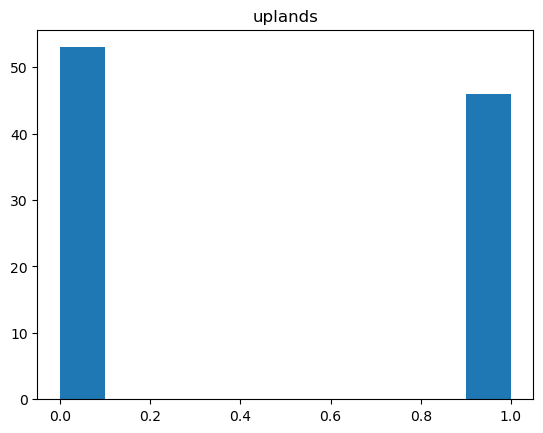

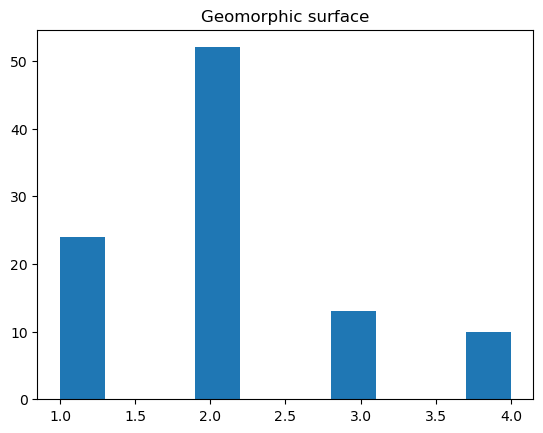

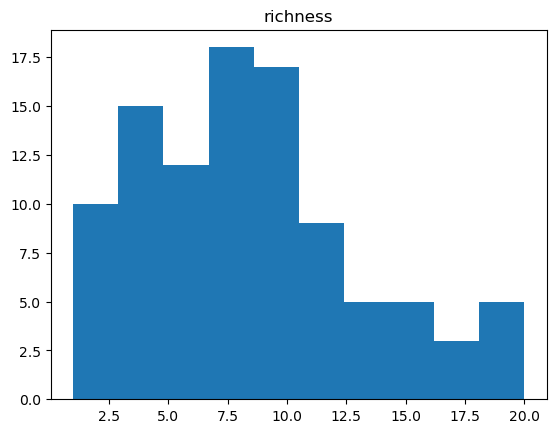

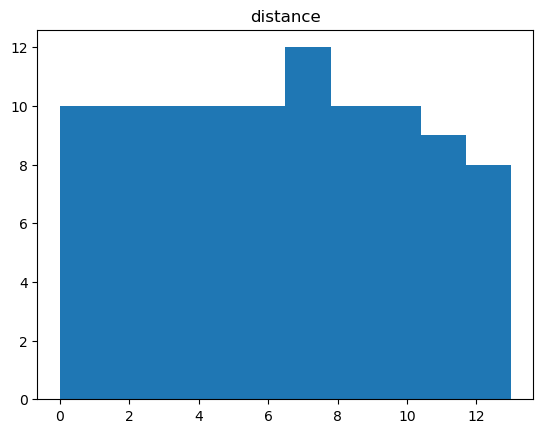

In [19]:
for i in tdf.columns:
    plt.hist(tdf[i])
    plt.title(i)
    plt.show()

All distributions are extremely non-normal, will need to use non-parametric models

In [20]:
drainage = tdf[tdf.uplands == 0].groupby(['Geomorphic surface']).mean()
uplands = tdf[tdf.uplands == 1].groupby(['Geomorphic surface']).mean()

In [21]:
tdf.columns

Index(['site', 'P.micro', 'B.jun', 'A.greg', 'S.mex', 'Lycium2', 'Lycium1',
       'S.chin', 'E.far', 'A.delt', 'L.tri', 'E.tri', 'H.emory', 'A.oides',
       'K.grey', 'F.splen', 'C.gig', 'O.test', 'O.acan', 'O.big', 'H.sal',
       'P.vel', 'P.flor', 'H.mono', 'C.lin', 'A.dum', 'uplands',
       'Geomorphic surface', 'richness', 'distance'],
      dtype='object')

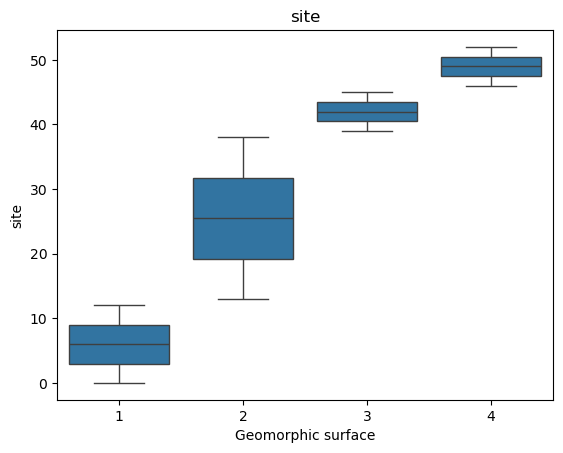

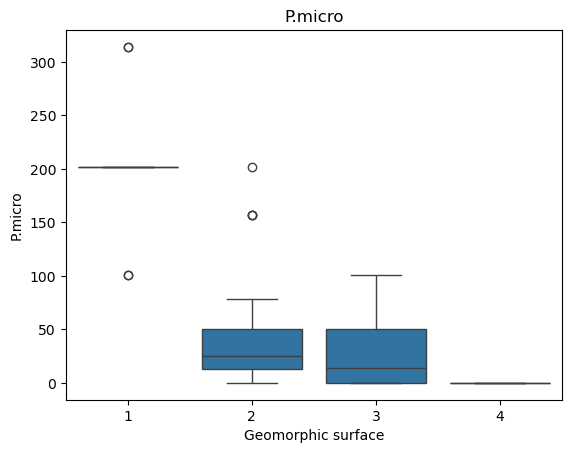

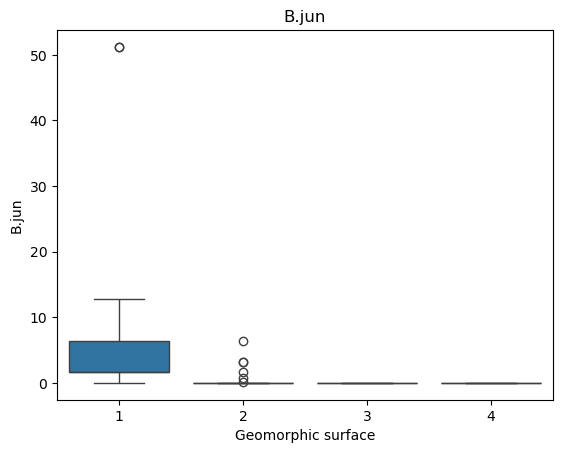

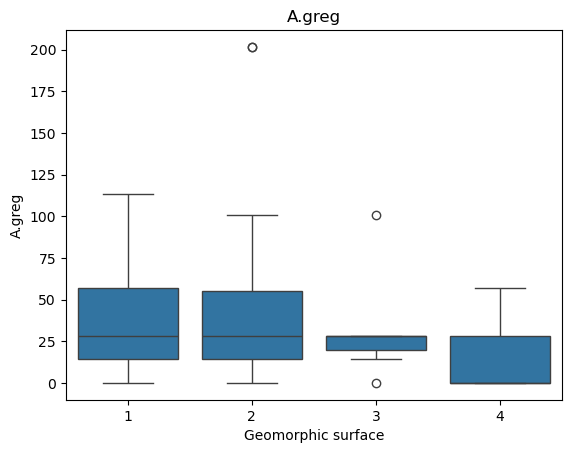

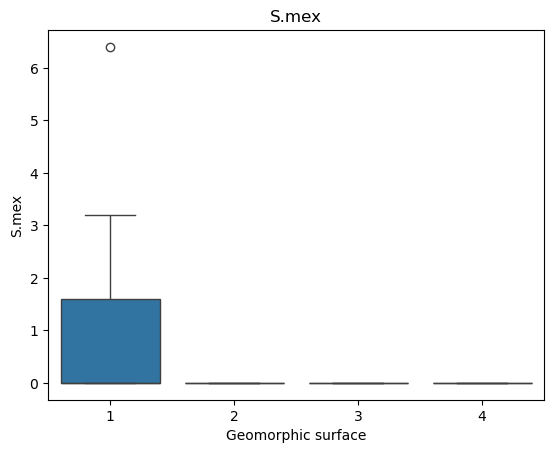

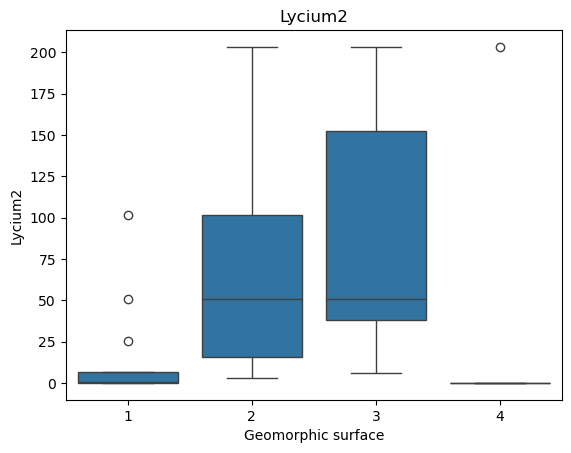

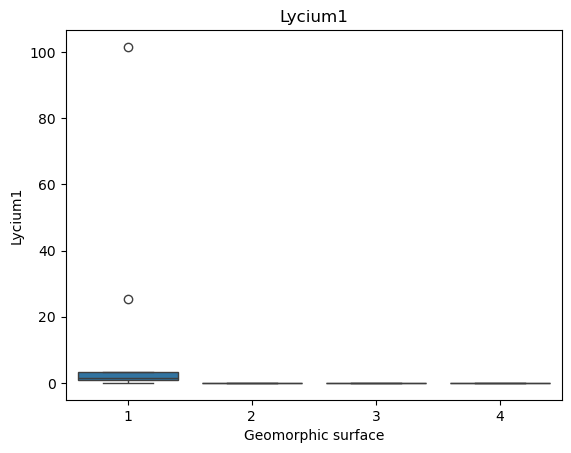

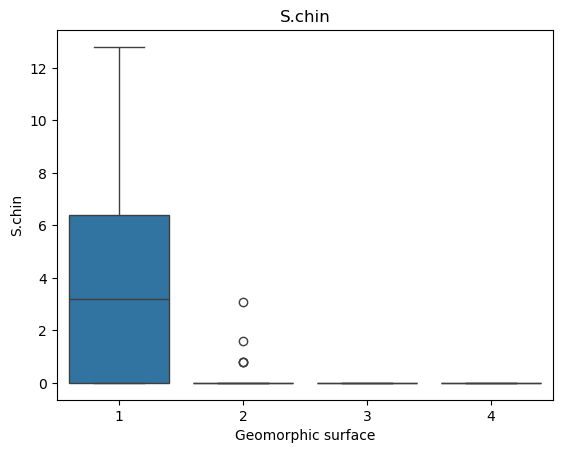

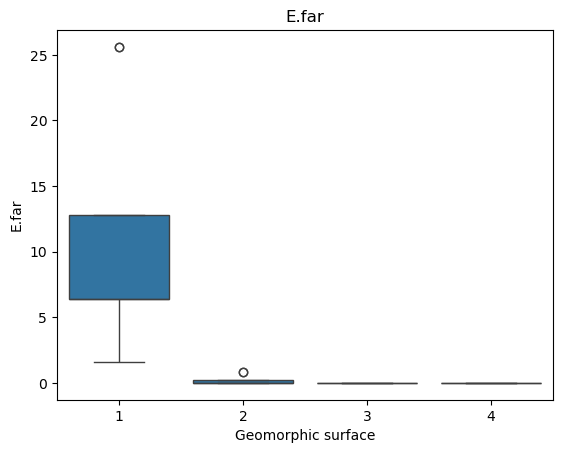

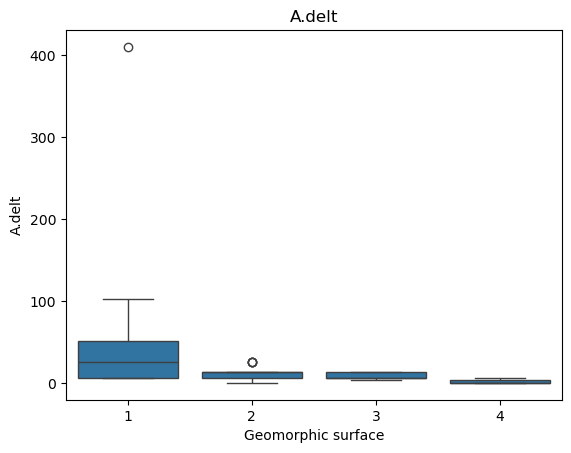

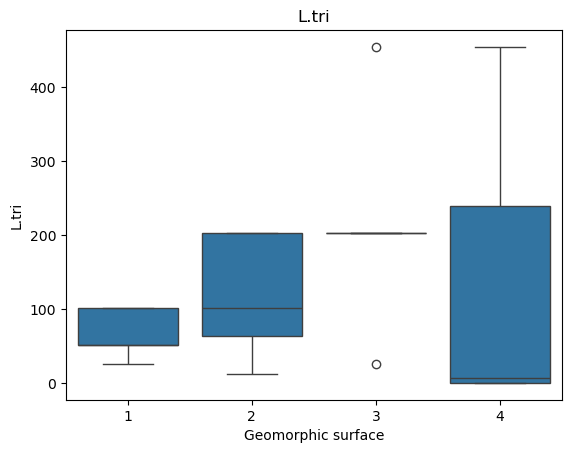

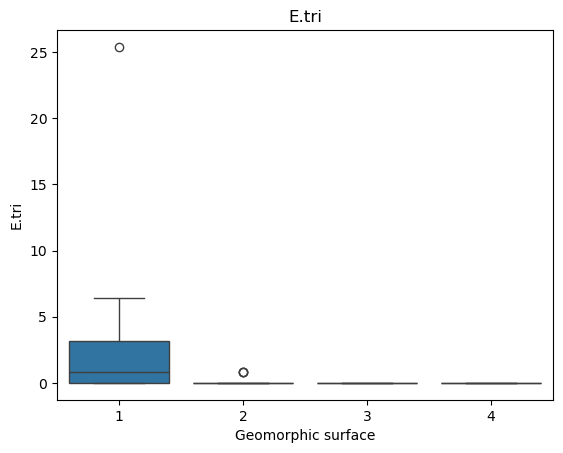

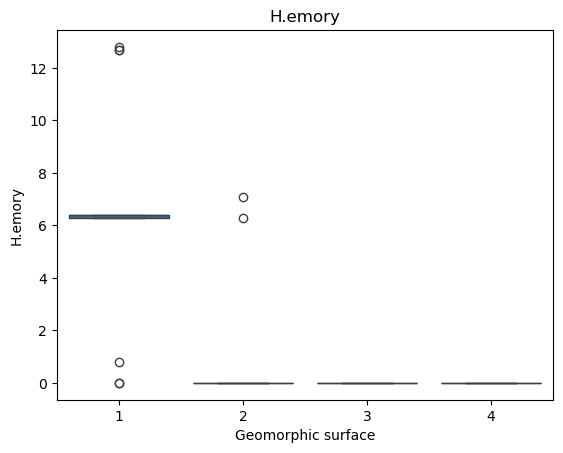

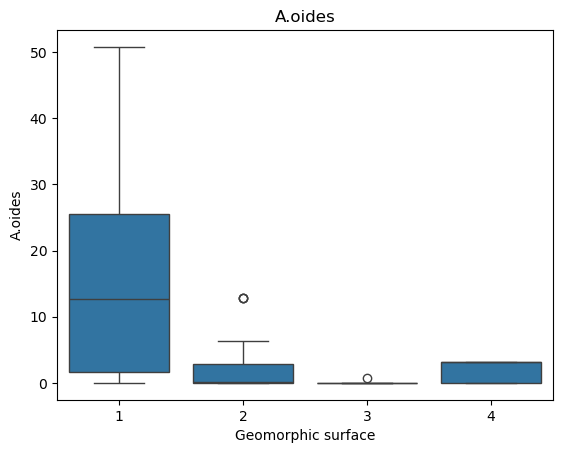

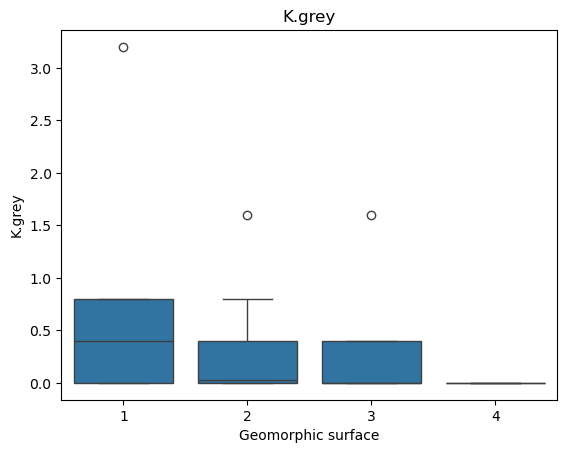

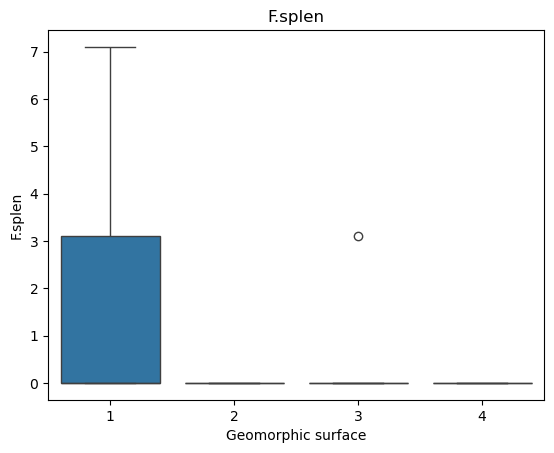

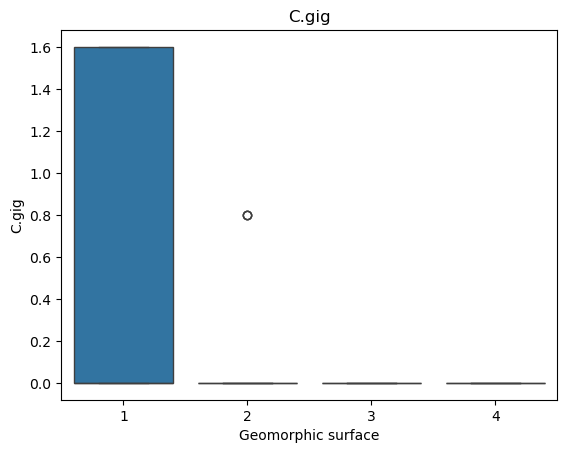

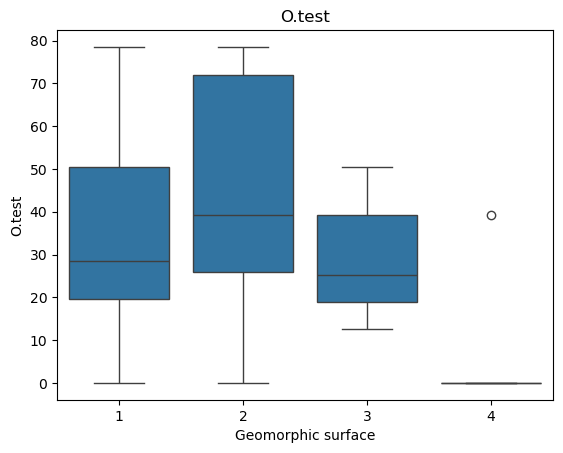

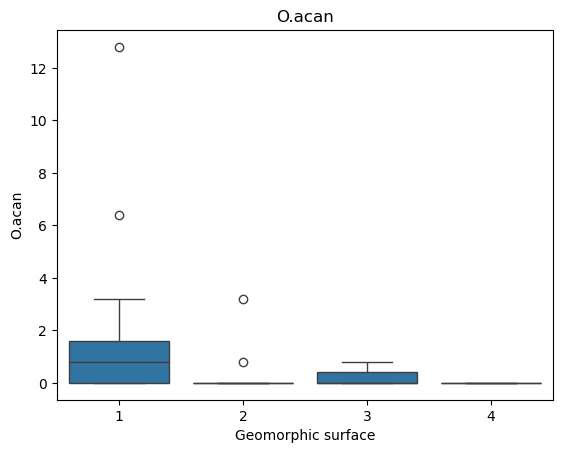

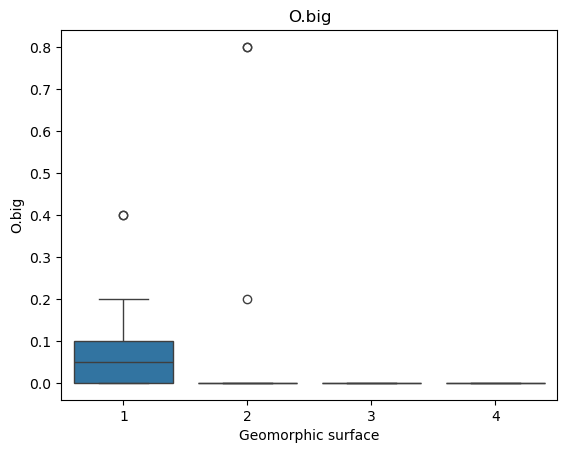

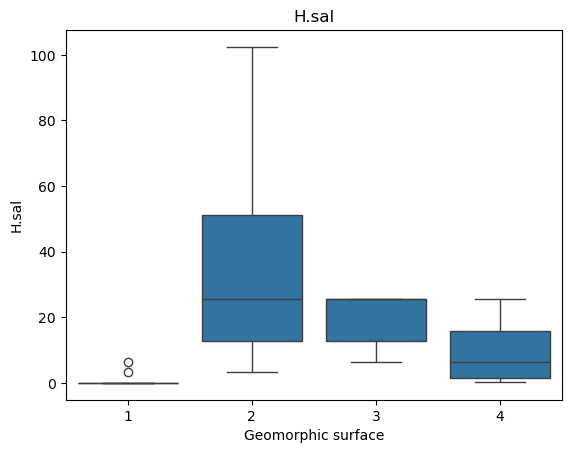

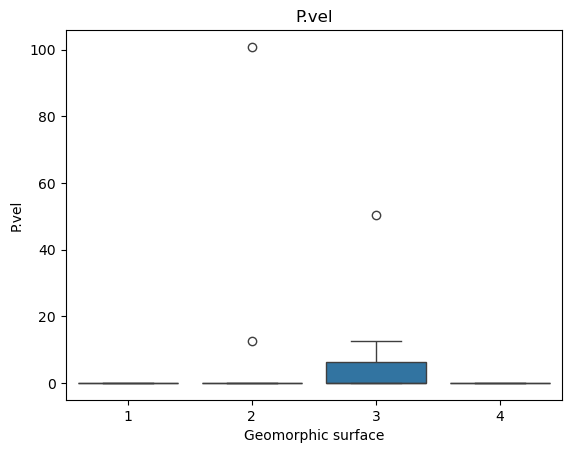

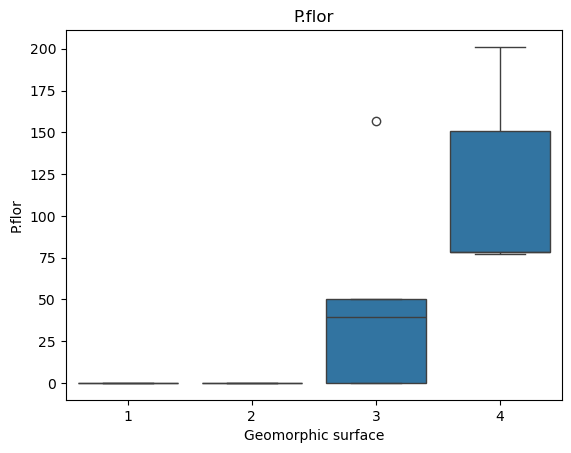

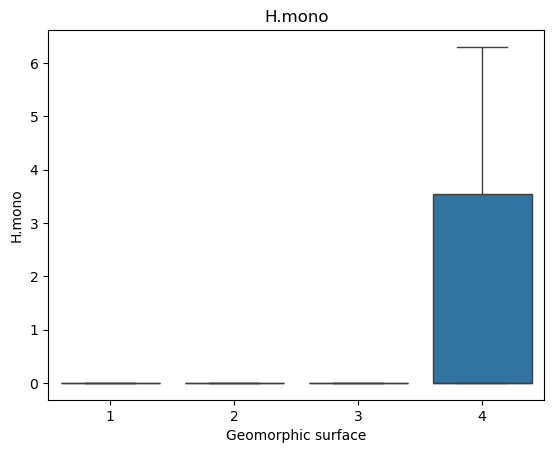

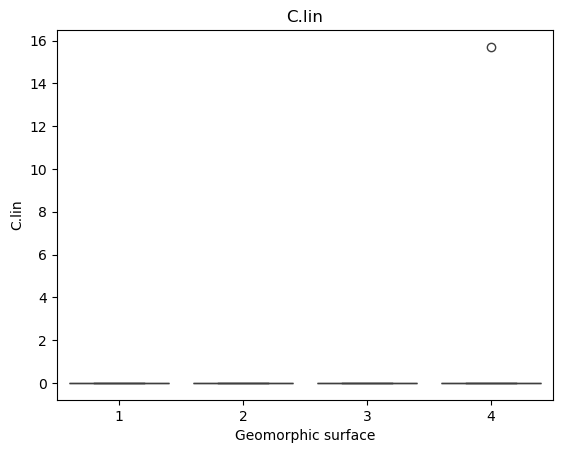

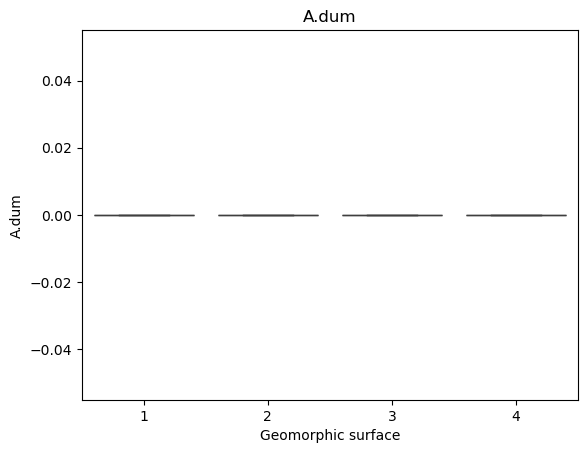

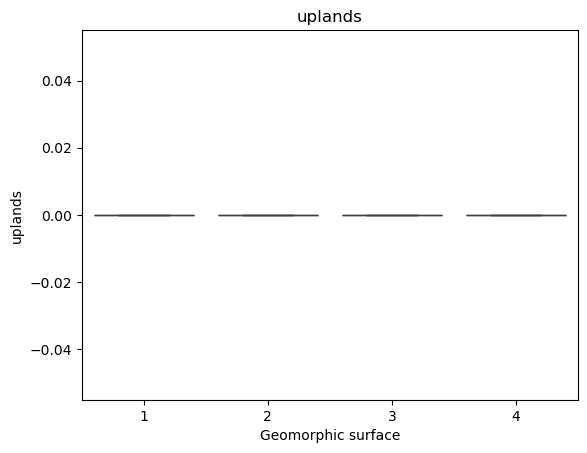

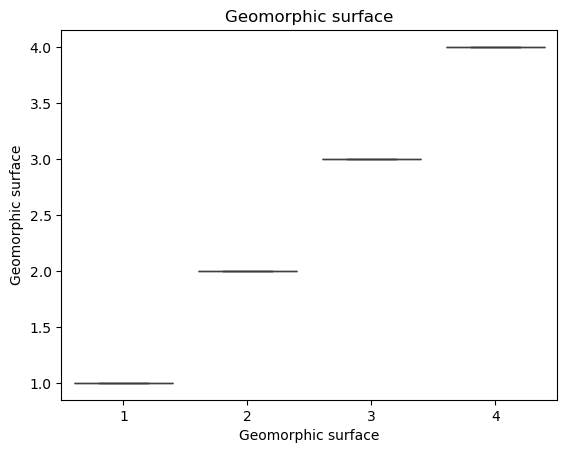

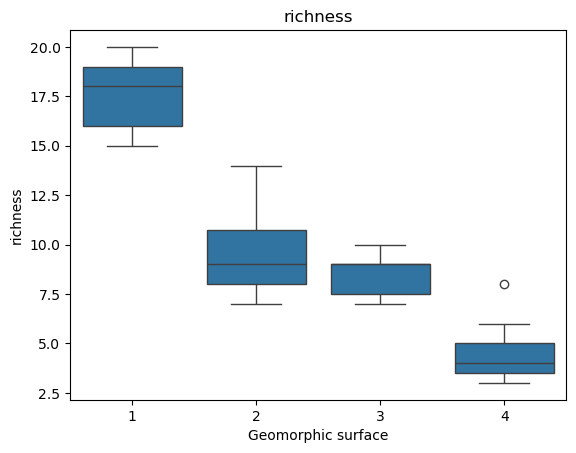

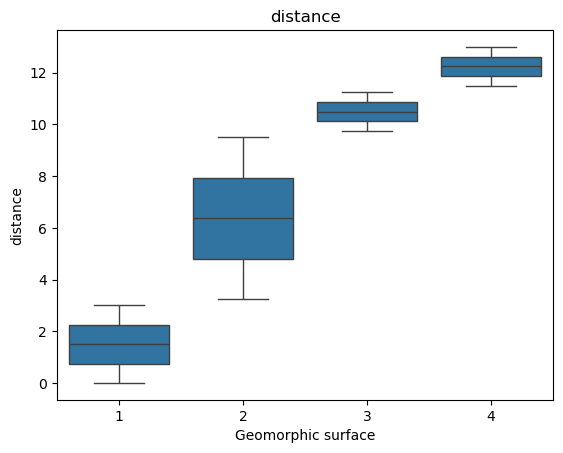

In [22]:
for i in tdf.columns:
    sns.boxplot(data = tdf[tdf.uplands == 0], x = 'Geomorphic surface', y = i)
    plt.title(i)
    plt.show()

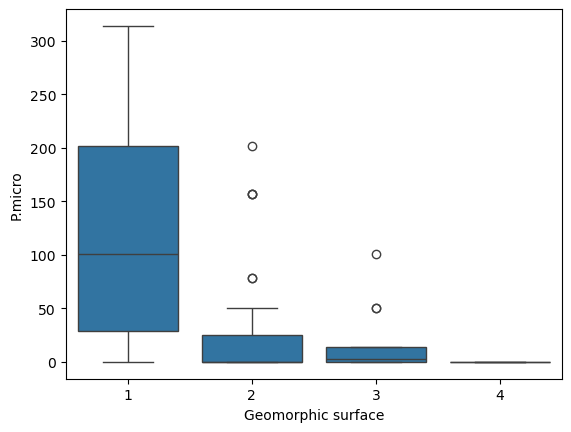

In [23]:
sns.boxplot(data = tdf, x = 'Geomorphic surface', y = 'P.micro')
plt.show()

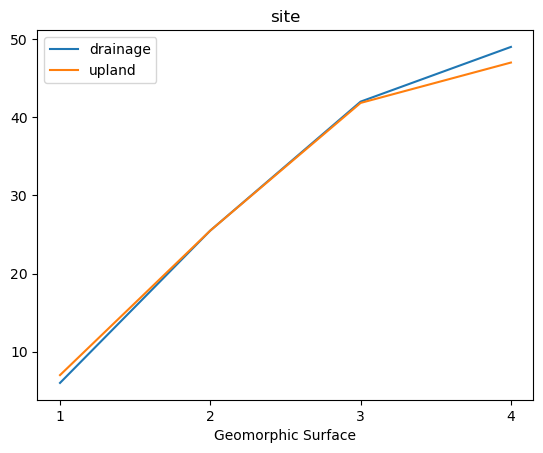

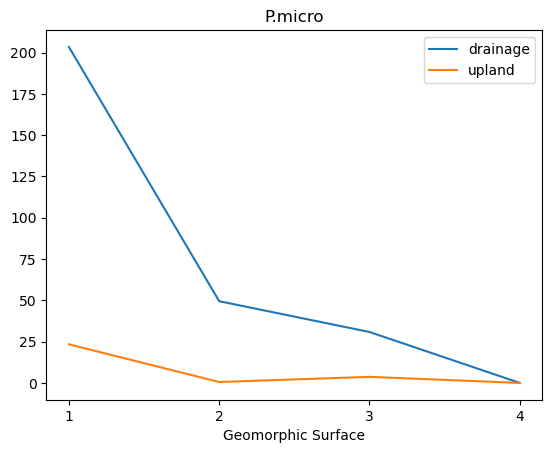

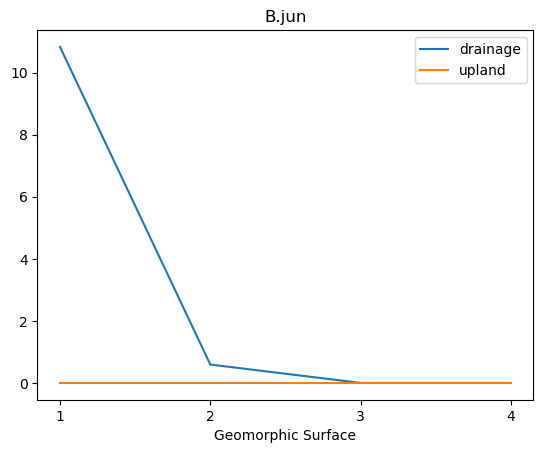

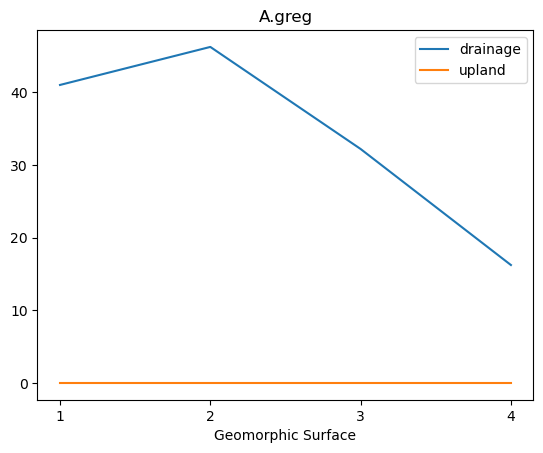

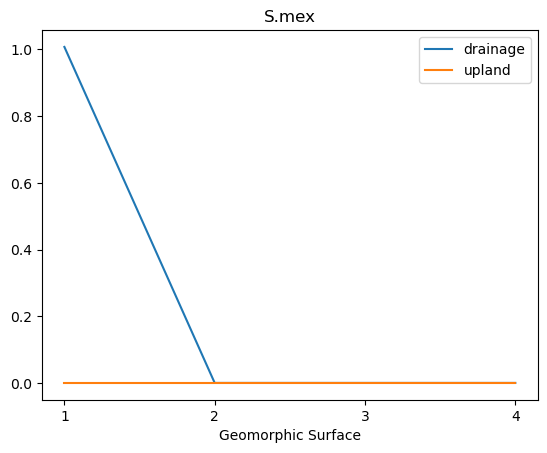

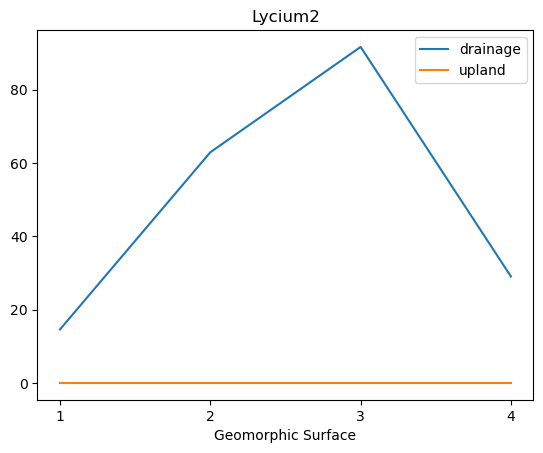

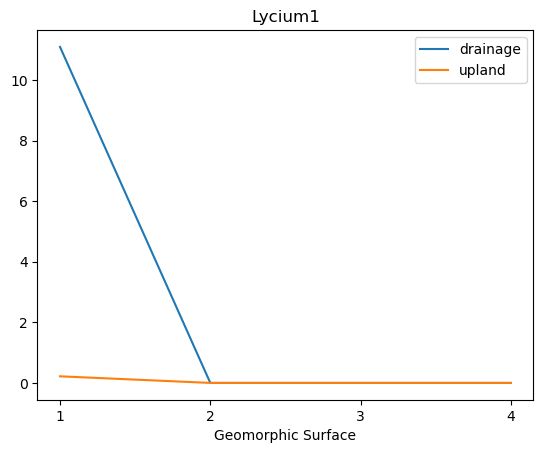

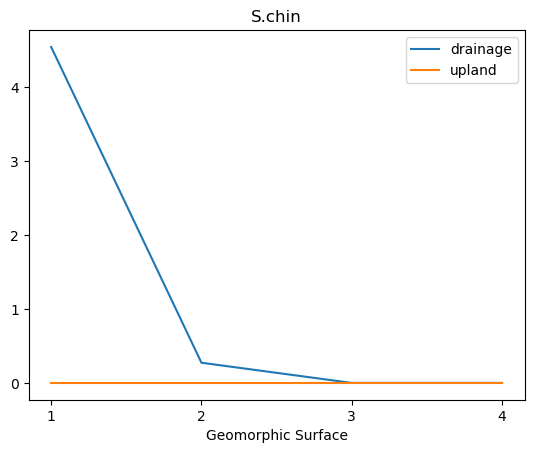

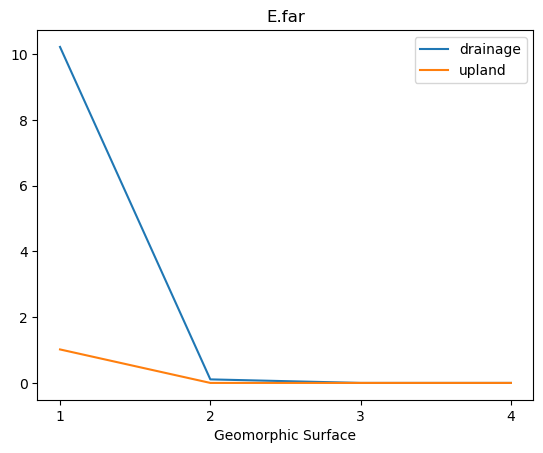

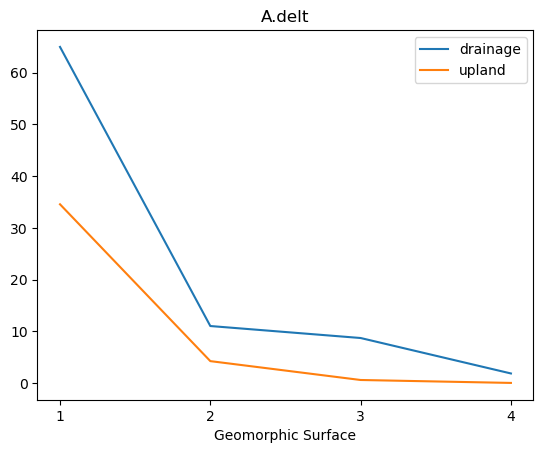

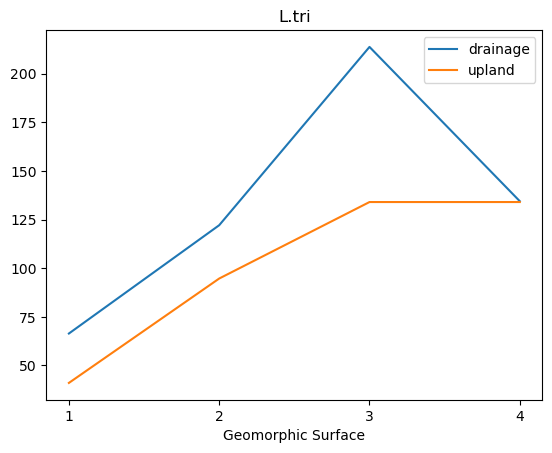

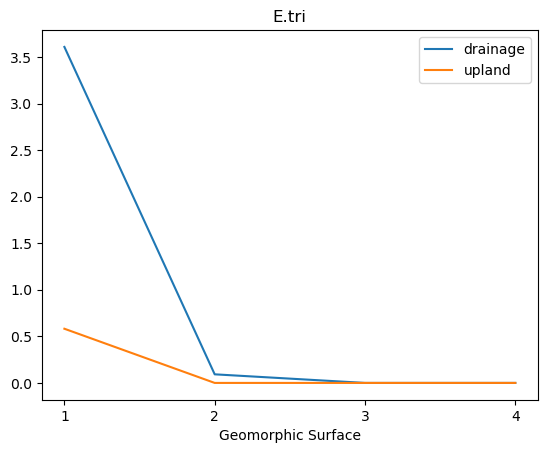

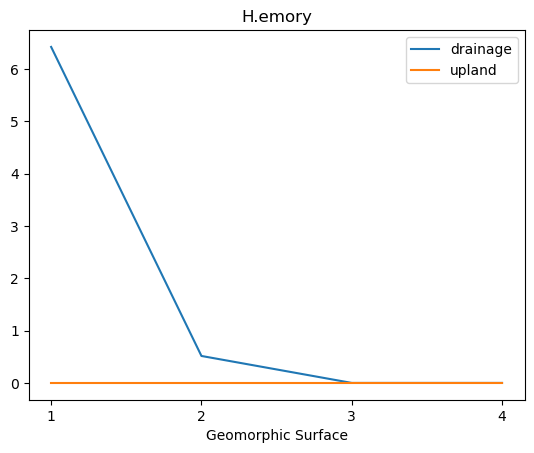

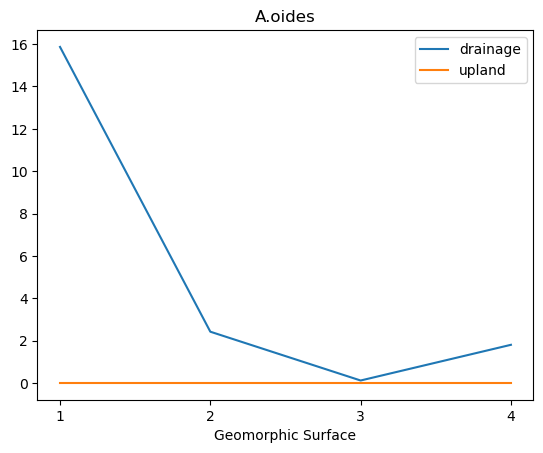

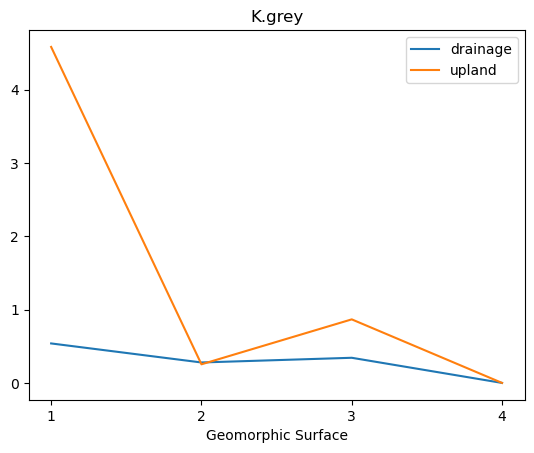

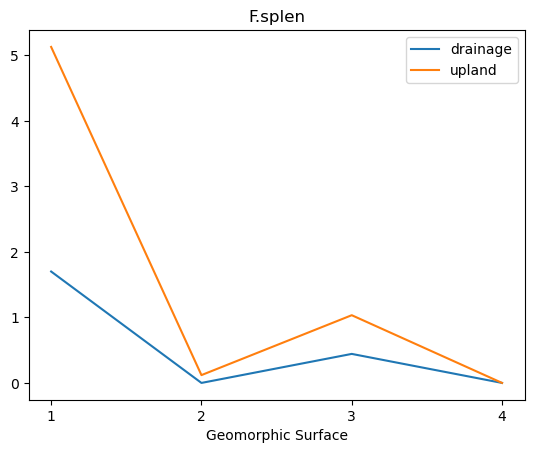

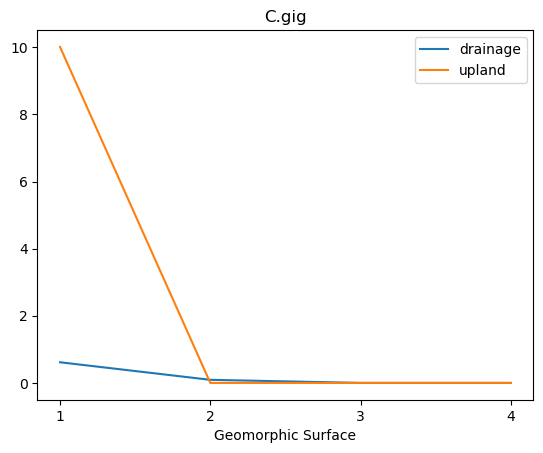

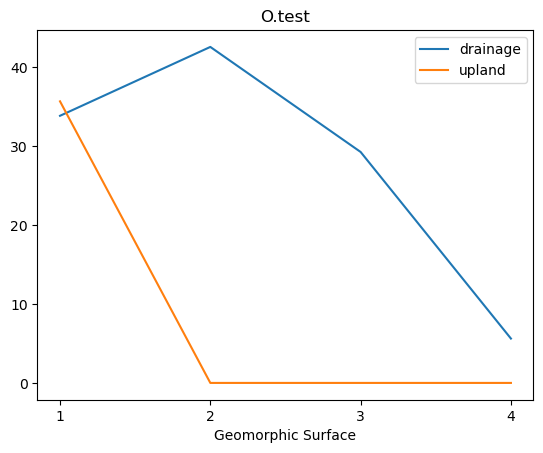

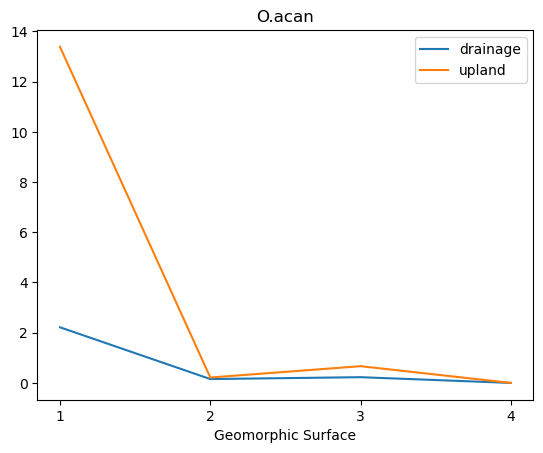

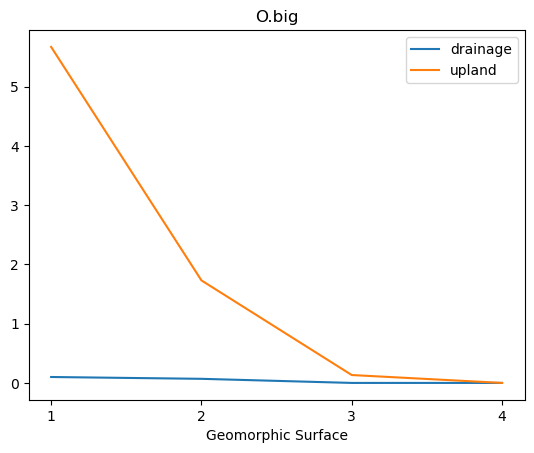

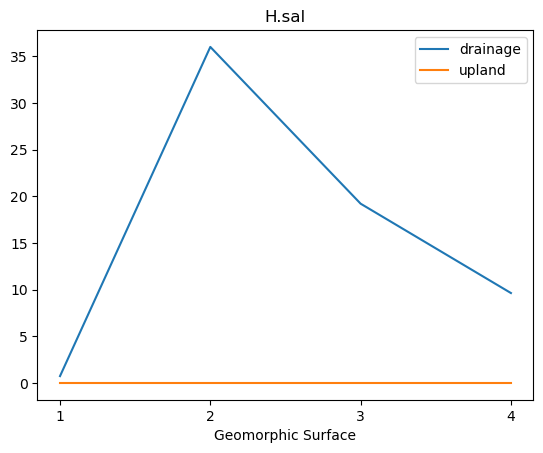

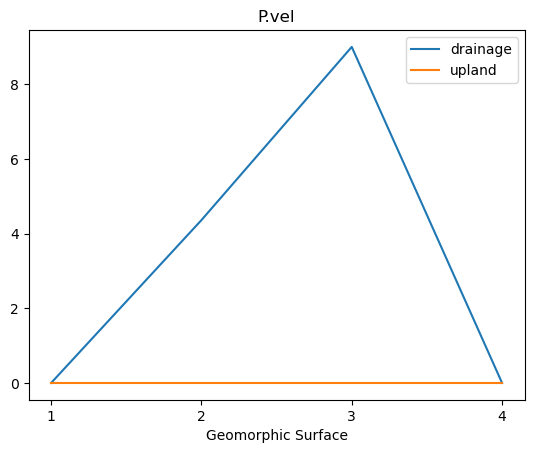

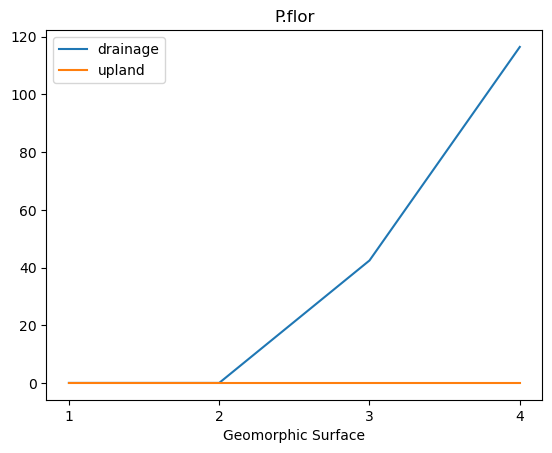

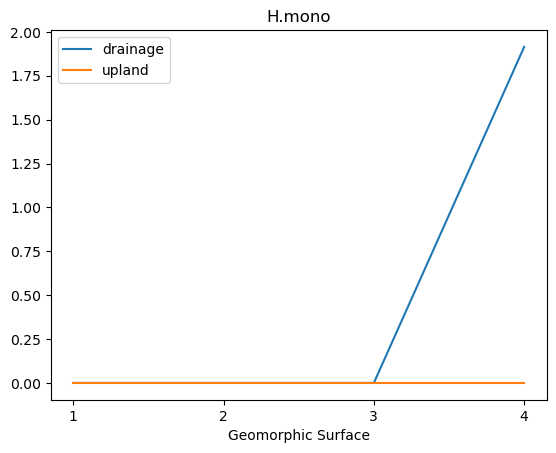

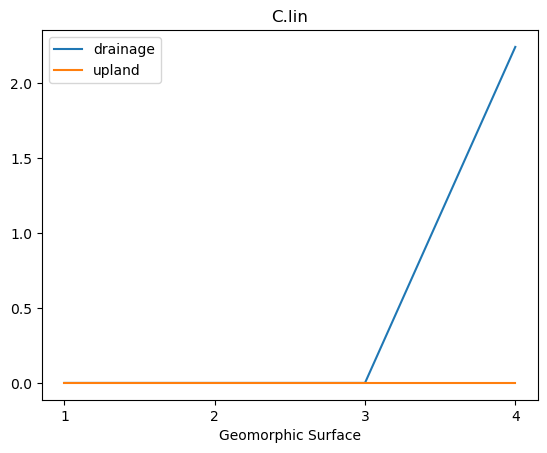

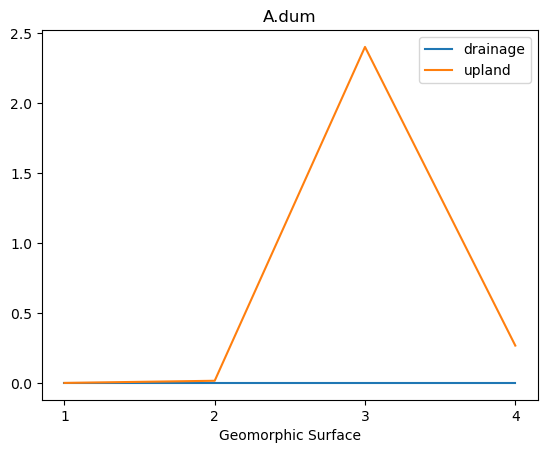

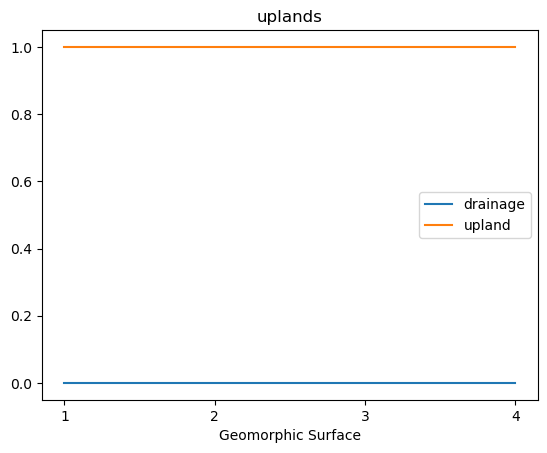

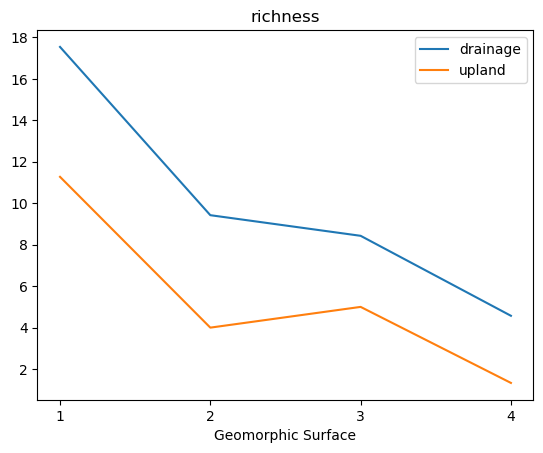

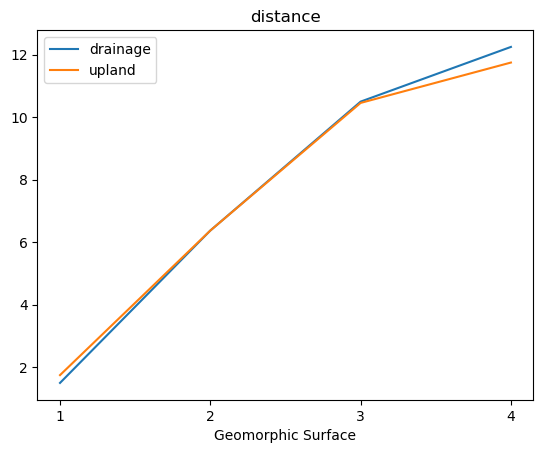

In [24]:
for i in drainage.columns:
    plt.plot(drainage.index, drainage[i], label = 'drainage')
    plt.plot(drainage.index, uplands[i], label = 'upland')
    plt.legend()
    plt.xticks([1, 2, 3, 4], [1, 2, 3, 4])
    plt.title(i)
    plt.xlabel('Geomorphic Surface')
    plt.show()

# Linear regression uplands vs drainage species richness

In [25]:
dX = sm.add_constant(tdf[tdf.uplands == 0].distance)
dmodel = sm.OLS(tdf[tdf.uplands == 0].richness, dX).fit()
dconf_intervals = dmodel.conf_int()
dpred = dmodel.get_prediction(dX)
dpred_summary = dpred.summary_frame(alpha=0.05)  # 95% confidence intervals
# Extract confidence intervals
dci_lower = dpred_summary['mean_ci_lower']
dci_upper = dpred_summary['mean_ci_upper']
dpi_lower = dpred_summary['obs_ci_lower']
dpi_upper = dpred_summary['obs_ci_upper']
#dmodel.summary()

In [26]:
dr2 = r2_score(tdf[tdf.uplands == 0].richness, dmodel.fittedvalues)
print('Drainage')
print('p-value =', dmodel.pvalues.values[1])
print('r2 =', dr2)

Drainage
p-value = 5.429208129824995e-18
r2 = 0.771844974546987


In [27]:
uX = sm.add_constant(tdf[tdf.uplands == 1].distance)
umodel = sm.OLS(tdf[tdf.uplands == 1].richness, uX).fit()
uconf_intervals = umodel.conf_int()
upred = umodel.get_prediction(uX)
upred_summary = upred.summary_frame(alpha=0.05)  # 95% confidence intervals
# Extract confidence intervals
uci_lower = upred_summary['mean_ci_lower']
uci_upper = upred_summary['mean_ci_upper']
upi_lower = upred_summary['obs_ci_lower']
upi_upper = upred_summary['obs_ci_upper']
#umodel.summary()

In [28]:
ur2 = r2_score(tdf[tdf.uplands == 1].richness, umodel.fittedvalues)
print('Uplands')
print('p-value =', umodel.pvalues.values[1])
print('r2 =', ur2)

Uplands
p-value = 1.9342757413960126e-10
r2 = 0.6057951090033291


In [29]:
umodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               richness   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     67.62
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           1.93e-10
Time:                        20:14:17   Log-Likelihood:                -103.45
No. Observations:                  46   AIC:                             210.9
Df Residuals:                      44   BIC:                             214.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8987      0.721     15.115      0.000       9.446      12.352
distance      -0.8457      0.103     -8.223      0.000      -1.053      -0.638
==============================================================================
Omnibus:                        4.858   Durbin-Watson:                   0.607
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                3.930
Skew:                           0.603   Prob(JB):                        0.140
Kurtosis:                       2.229   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

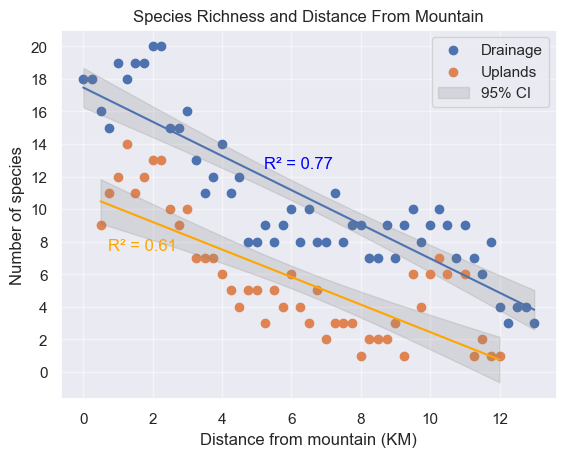

In [30]:
sns.set()
plt.scatter(tdf[tdf.uplands == 0].distance, tdf[tdf.uplands == 0].richness, label = 'Drainage')
plt.plot(tdf[tdf.uplands == 0].distance, dmodel.fittedvalues)
plt.fill_between(tdf[tdf.uplands == 0].distance, dci_lower, dci_upper, color='gray', alpha=0.2)

plt.scatter(tdf[tdf.uplands == 1].distance, tdf[tdf.uplands == 1].richness, label = 'Uplands')
plt.plot(tdf[tdf.uplands == 1].distance, umodel.fittedvalues, color='orange')
plt.fill_between(tdf[tdf.uplands == 1].distance, uci_lower, uci_upper, color='gray', alpha=0.2, label='95% CI')

plt.yticks(range(0, 21, 2), range(0, 21, 2))
plt.legend()
plt.text(5.2, 12.5, f'R\u00b2 = {round(dr2, 2)}', fontsize = 12, color = 'blue')
plt.text(0.7, 7.5, f'R\u00b2 = {round(ur2, 2)}', fontsize = 12, color = 'orange')
plt.title('Species Richness and Distance From Mountain')
plt.xlabel('Distance from mountain (KM)')
plt.ylabel('Number of species')
plt.grid(':', alpha = 0.5)
plt.savefig("docs/distance_uplands_drainage.png", dpi=300, bbox_inches="tight")
plt.show()

## t-tests

In [31]:
paired_df = tdf[tdf.uplands == 1][['distance', 'richness']].merge(tdf[tdf.uplands == 0][['distance', 'richness']], left_on = 'distance', right_on = 'distance')
paired_df.rename(columns = {'richness_x' : 'upland_plants', 'richness_y' : 'drainage'}, inplace = True)

In [32]:
print('Drainages on average have', round((paired_df.drainage - paired_df.upland_plants).mean(), 2), 'more species than the adjacent uplands.')

Drainages on average have 5.33 more species than the adjacent uplands.


In [33]:
paired_df['diff'] = paired_df.drainage - paired_df.upland_plants

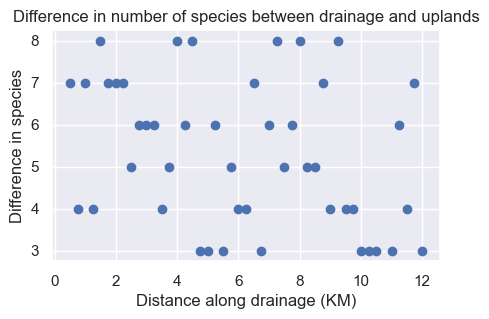

In [34]:
plt.figure(figsize = (5, 3))
plt.scatter(paired_df.distance, paired_df['diff'])
plt.title('Difference in number of species between drainage and uplands')
plt.ylabel('Difference in species')
plt.xlabel('Distance along drainage (KM)')
plt.show()

In [35]:
print('paired t-test p-value =', format(round(stats.ttest_rel(paired_df.upland_plants, paired_df.drainage).pvalue, 10), ".10f"))

paired t-test p-value = 0.0000000000


In [36]:
print('Independent sample t-test p-value =', format(round(stats.ttest_ind(paired_df.upland_plants, paired_df.drainage).pvalue, 10), ".10f"))

Independent sample t-test p-value = 0.0000000043


In [37]:
def statistic(x, y):
    return np.mean(x) - np.mean(y)

In [38]:
perm_test = stats.permutation_test(data=(paired_df.upland_plants, paired_df.drainage), statistic = statistic, n_resamples = 10000, alternative = 'less')
print('difference of means with 10,000 resample permutation p-value =', format(round(perm_test.pvalue, 10), ".10f"))

difference of means with 10,000 resample permutation p-value = 0.0000999900


In [39]:
print('ANCOVA difference between upland and drainage species regression p-value =', format(round(ancova(data = tdf, dv = 'richness', covar = 'distance', between = 'uplands')['p-unc'][0], 10), ".10f"))

ANCOVA difference between upland and drainage species regression p-value = 0.0000000000


# MDS

In [40]:
tdf['upland_drainage'] = tdf['uplands'] * 4 + tdf['Geomorphic surface']

In [41]:
tdf.drop(columns = {'richness', 'distance', 'site'}, inplace = True)

In [42]:
tdf.drop(columns = ['S.mex'], inplace = True)

## Uplands

In [43]:
transformer = QuantileTransformer(output_distribution='normal', n_quantiles = 5)
transformed = transformer.fit_transform(tdf[tdf.uplands.isin([1])].drop(columns = ['Geomorphic surface', 'uplands', 'upland_drainage']))

In [44]:
scaled_tdf = pd.DataFrame(transformed)
scaled_tdf.columns = tdf.columns[:-3]

In [45]:
mds = MDS(n_components=3, max_iter=100000, metric=True, dissimilarity='precomputed', random_state=42)
dist = DistanceMetric.get_metric('braycurtis')
D_original = dist.pairwise(scaled_tdf)

# Fit MDS
X_mds = mds.fit_transform(D_original)
mdsx = pd.DataFrame(X_mds)

# Raw stress from sklearn
print("Raw stress:", mds.stress_)
D_mds = pairwise_distances(X_mds)

# Normalized Kruskal Stress-1
stress_norm = np.sqrt(np.sum((D_original - D_mds) ** 2) / np.sum(D_original ** 2))
print("Normalized stress (Stress-1):", stress_norm)

Raw stress: 0.26330688113802514
Normalized stress (Stress-1): 0.08842078802878311


In [46]:
mdsx.columns = ['b-mds0', 'b-mds1', 'b-mds2']
mdsx['Geomorphic surface'] = tdf['Geomorphic surface']
mdsx['uplands'] = tdf['uplands']

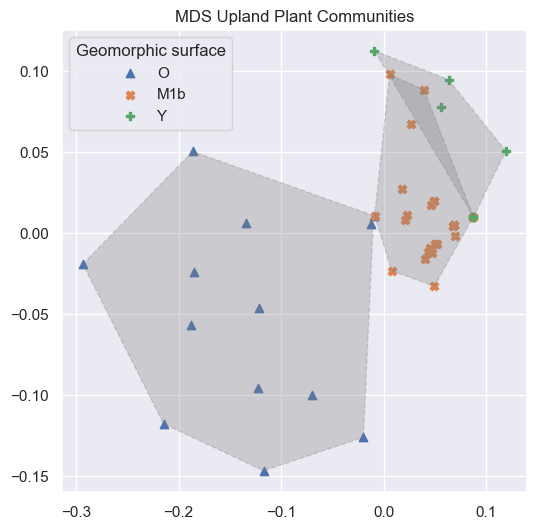

In [47]:
labels = mdsx['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):  #zip(labels, ['Drainage', 'Uplands'], ['^', 'X']):
    group_df = mdsx[mdsx['Geomorphic surface'] == label]
    points = group_df[['b-mds2', 'b-mds0']].values
    ax.scatter(group_df['b-mds2'], group_df['b-mds0'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic surface')
plt.title('MDS Upland Plant Communities')
#plt.savefig("docs/uplands_mds.png", dpi=300, bbox_inches="tight")
plt.show()

## Drainage

In [48]:
transformer = QuantileTransformer(output_distribution='normal', n_quantiles = 5) 
transformed = transformer.fit_transform(tdf[tdf.uplands.isin([0])].drop(columns = ['Geomorphic surface', 'uplands', 'upland_drainage']))

In [49]:
#scaled_tdf = pd.DataFrame(scaled)
scaled_tdf = pd.DataFrame(transformed)
scaled_tdf.columns = tdf.columns[:-3]

In [50]:
mds = MDS(n_components=5, max_iter=100000, metric=True, dissimilarity='precomputed', random_state=42)
dist = DistanceMetric.get_metric('braycurtis')
D_original = dist.pairwise(scaled_tdf)

# Fit MDS
X_mds = mds.fit_transform(D_original)
mdsx = pd.DataFrame(X_mds)
print("Raw stress:", mds.stress_)
D_mds = pairwise_distances(X_mds)

# Normalized Kruskal Stress-1
stress_norm = np.sqrt(np.sum((D_original - D_mds) ** 2) / np.sum(D_original ** 2))
print("Normalized stress (Stress-1):", stress_norm)

Raw stress: 1.0751276413414987
Normalized stress (Stress-1): 0.0778688894226224


In [51]:
mdsx.columns = ['b-mds0', 'b-mds1', 'b-mds2', 'b-mds3', 'b-mds4']
mdsx['Geomorphic surface'] = tdf['Geomorphic surface']
mdsx['uplands'] = tdf['uplands']

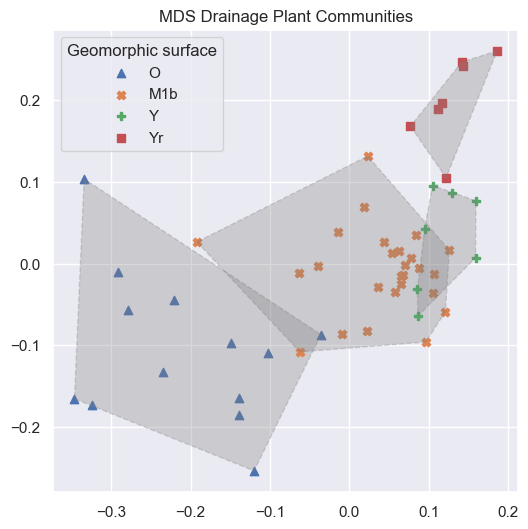

In [52]:
labels = mdsx['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):  #zip(labels, ['Drainage', 'Uplands'], ['^', 'X']):
    group_df = mdsx[mdsx['Geomorphic surface'] == label]
    points = group_df[['b-mds2', 'b-mds4']].values
    ax.scatter(group_df['b-mds2'], group_df['b-mds4'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic surface')
plt.title('MDS Drainage Plant Communities')
#plt.savefig("docs/drainage_mds.png", dpi=300, bbox_inches="tight")
plt.show()

## Upland and drainage

In [53]:
transformer = QuantileTransformer(output_distribution='normal', n_quantiles = 5) 
transformed = transformer.fit_transform(tdf.drop(columns = ['Geomorphic surface', 'uplands', 'upland_drainage']))

scaled_tdf = pd.DataFrame(transformed)
scaled_tdf.columns = tdf.columns[:-3]

mds = MDS(n_components = 3, max_iter = 100000, metric = False, dissimilarity = 'precomputed')

dist = DistanceMetric.get_metric('braycurtis')
#dist = DistanceMetric.get_metric('euclidean')

mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(scaled_tdf)))
mds.stress_

np.float64(0.23979358712300258)

In [54]:
mds = MDS(n_components=4, max_iter=100000, metric=True, dissimilarity='precomputed', random_state=42)
dist = DistanceMetric.get_metric('braycurtis')
D_original = dist.pairwise(scaled_tdf)

# Fit MDS
X_mds = mds.fit_transform(D_original)
mdsx = pd.DataFrame(X_mds)
print("Raw stress:", mds.stress_)
D_mds = pairwise_distances(X_mds)

# Normalized Kruskal Stress-1
stress_norm = np.sqrt(np.sum((D_original - D_mds) ** 2) / np.sum(D_original ** 2))
print("Normalized stress (Stress-1):", stress_norm)

Raw stress: 2.905868037926892
Normalized stress (Stress-1): 0.07873501063133297


In [55]:
mdsx.columns = ['b-mds0', 'b-mds1', 'b-mds2', 'b-mds3']
mdsx['upland_drainage'] = tdf['upland_drainage']
mdsx['uplands'] = tdf['uplands']

surface = ['O drainage', 'M1b drainage', 'Y drainage', 'Yr drainage', 'O upland', 'M1b upland', 'Y upland'] #, 'Yr upland'
mrk = ['^', 'X', 'P', ',', '1', '2', '3', '4']

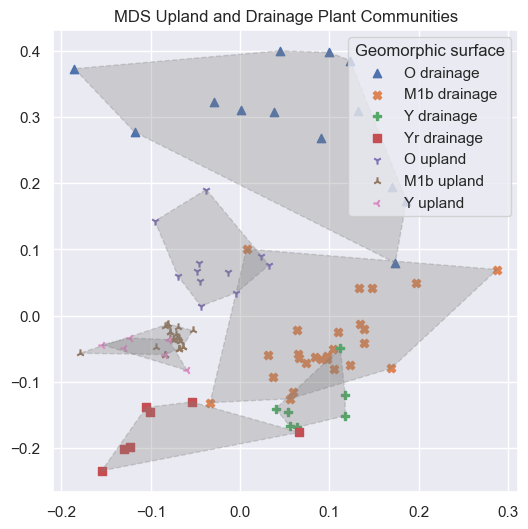

In [56]:
labels = mdsx['upland_drainage'].unique()
fig, ax = plt.subplots(figsize=(6,6))
sns.set()

for label, l, s in zip(labels, surface, mrk):
    group_df = mdsx[mdsx['upland_drainage'] == label]
    points = group_df[['b-mds2', 'b-mds3']].values
    # scatter points
    ax.scatter(group_df['b-mds2'], group_df['b-mds3'], 
               label=l, edgecolor=None, marker=s)
    # convex hull only if >= 3 unique points
    if len(points) >= 3:
        unique_points = np.unique(points, axis=0)
        if len(unique_points) >= 3:  # need at least 3 non-collinear points
            try:
                hull = ConvexHull(unique_points)
                polygon_points = unique_points[hull.vertices]
                poly = patches.Polygon(polygon_points, alpha=0.3, 
                                       fill=True, linestyle='--', color='gray')
                ax.add_patch(poly)
            except Exception as e:
                print(f"Skipping hull for {label}: {e}")

plt.legend(title='Geomorphic surface')
plt.title('MDS Upland and Drainage Plant Communities')
#plt.savefig("docs/upland_drainage_mds.png", dpi=300, bbox_inches="tight")
plt.show()

# Permutaion hypothesis testing

In [57]:
plants = tdf.drop(columns = ['uplands', 'Geomorphic surface', 'upland_drainage'])

In [58]:
# Distance matrix
bc = pairwise_distances(plants, metric="braycurtis")
bc_dm = DistanceMatrix(bc, ids=plants.index)

# PERMANOVA
all_results = permanova(bc_dm, grouping=tdf.upland_drainage.values, permutations=999)
all_results

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      99
number of groups                  8
test statistic            25.903618
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [59]:
groups = tdf.upland_drainage.unique()

results = []

for g1, g2 in itertools.combinations(groups, 2):
    ids = tdf[tdf.upland_drainage.isin([g1, g2])].index
    sub_dm = bc_dm.filter(ids, strict=False)
    grouping = tdf.loc[ids, 'upland_drainage'].values
    #PERMANOVA
    res = permanova(sub_dm, grouping=grouping, permutations=999)
    print("surface", g1, "and surface", g2, "test stat", res["test statistic"], 'p-value', res['p-value'])

surface 1.0 and surface 2.0 test stat 19.587815778426 p-value 0.001
surface 1.0 and surface 3.0 test stat 18.048941684326874 p-value 0.001
surface 1.0 and surface 4.0 test stat 26.642727450111433 p-value 0.001
surface 1.0 and surface 5.0 test stat 24.432326909510675 p-value 0.001
surface 1.0 and surface 6.0 test stat 107.32429850111748 p-value 0.001
surface 1.0 and surface 7.0 test stat 34.47030379143586 p-value 0.001
surface 1.0 and surface 8.0 test stat 19.628231857111867 p-value 0.002
surface 2.0 and surface 3.0 test stat 2.896929220979935 p-value 0.011
surface 2.0 and surface 4.0 test stat 23.24932440365459 p-value 0.001
surface 2.0 and surface 5.0 test stat 22.255621898407426 p-value 0.001
surface 2.0 and surface 6.0 test stat 59.121638764366715 p-value 0.001
surface 2.0 and surface 7.0 test stat 13.589385323947273 p-value 0.001
surface 2.0 and surface 8.0 test stat 7.3659334069946425 p-value 0.001
surface 3.0 and surface 4.0 test stat 8.342000713791776 p-value 0.008
surface 3.0 a

For p-value < 0.05, all upland and drainage species are statistically different, all channel morphology types are different from each other, upland Y and Yr are not different from each other, upland M1b and upland Yr are not different from each other.  

# Random Forest

In [60]:
X = tdf.drop(columns = ['uplands', 'Geomorphic surface', 'upland_drainage'])
y = tdf.upland_drainage.astype(str)

In [61]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
y_pred = rfc.predict(X)
rfc.score(X, y)

0.9696969696969697

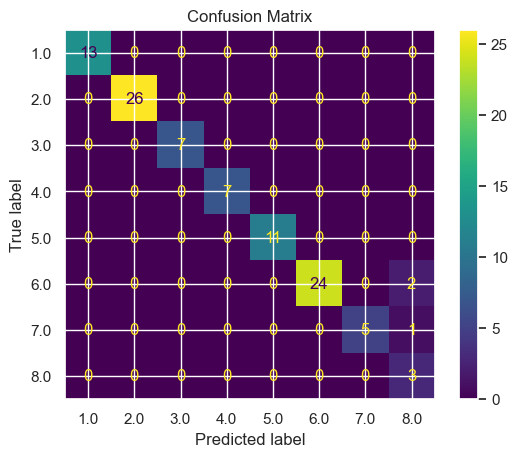

In [62]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [63]:
print(classification_report(y, y_pred, target_names=rfc.classes_))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        13
         2.0       1.00      1.00      1.00        26
         3.0       1.00      1.00      1.00         7
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      0.92      0.96        26
         7.0       1.00      0.83      0.91         6
         8.0       0.50      1.00      0.67         3

    accuracy                           0.97        99
   macro avg       0.94      0.97      0.94        99
weighted avg       0.98      0.97      0.97        99



In [64]:
importance = pd.DataFrame()
importance['feature'] = X.columns
importance['importance'] = rfc.feature_importances_
importance.sort_values('importance', ascending = False)

,feature,importance
18,H.sal,0.127029
0,P.micro,0.091146
7,A.delt,0.088367
2,A.greg,0.075679
3,Lycium2,0.070763
8,L.tri,0.065591
20,P.flor,0.060980
16,O.acan,0.059574
15,O.test,0.053808
6,E.far,0.040174


In [65]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X)

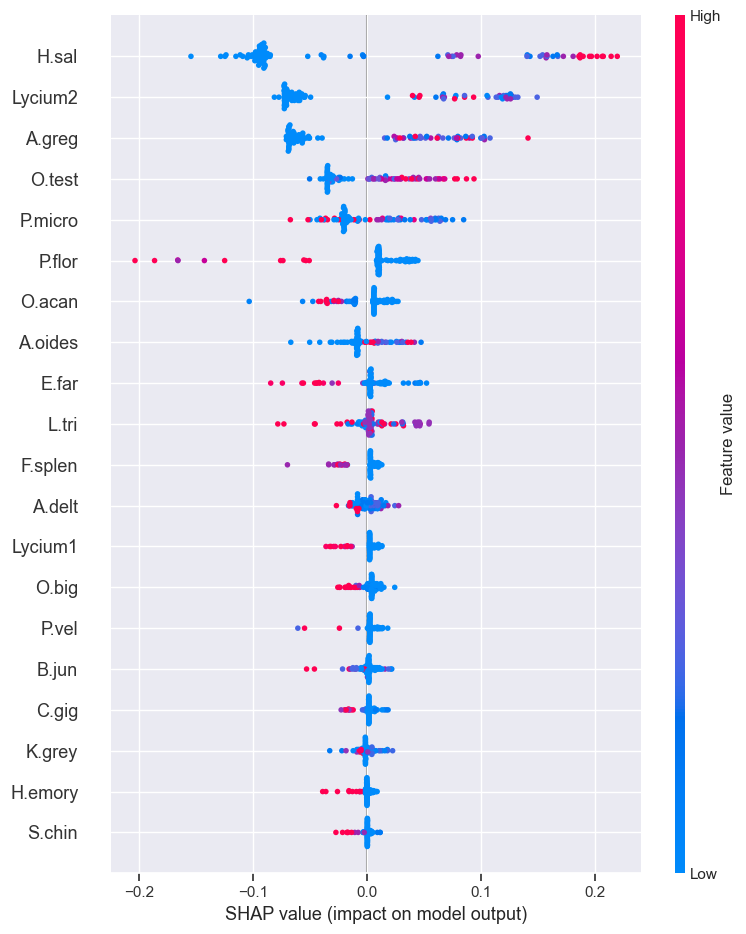

In [66]:
shap.summary_plot(shap_values[:, :, 1], X, class_names = rfc.classes_)

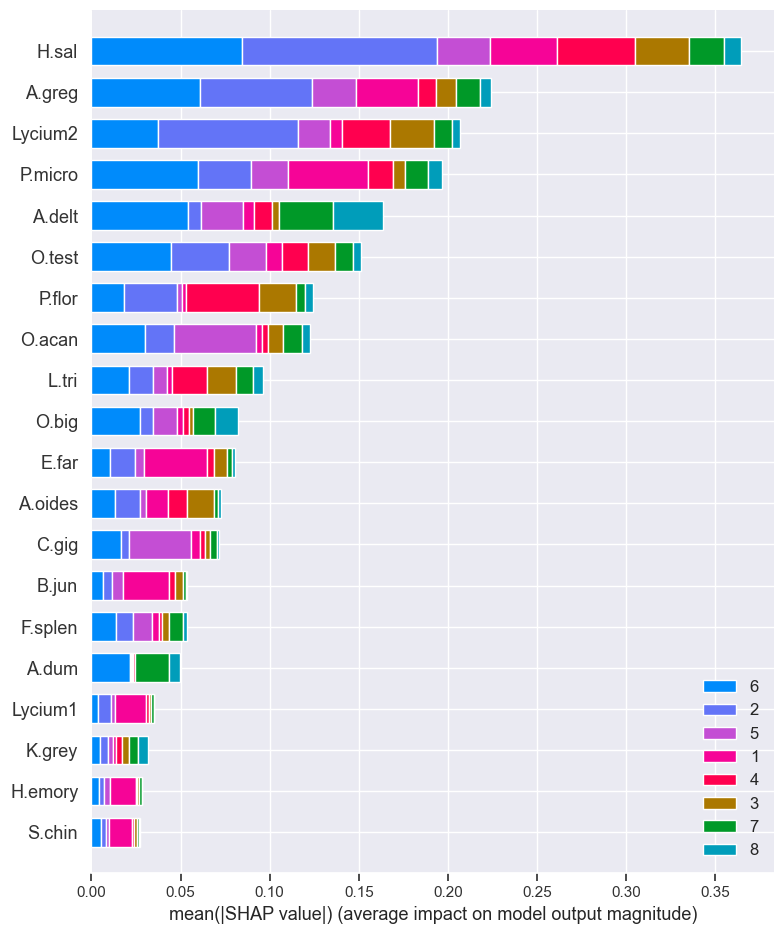

In [67]:
exp = explainer(X)

shap.summary_plot(exp, X, plot_type="bar", class_names=[1, 2, 3, 4, 5, 6, 7, 8], feature_names=X.columns)

In [68]:
s_2d = UMAP.UMAP(n_components = 2, n_neighbors = 10, min_dist=0).fit_transform(shap_values[:, :, 0])
shap_2d = pd.DataFrame(s_2d)
shap_2d['upland_drainage'] = y

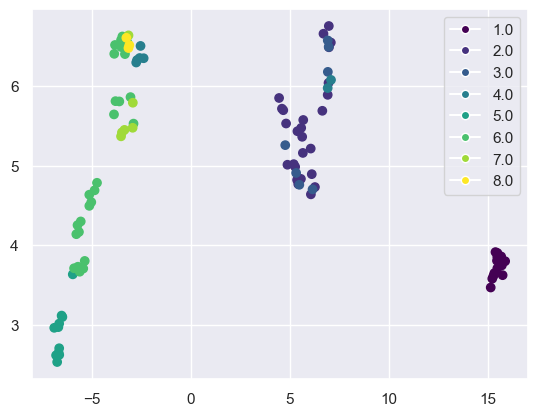

In [69]:
cmap = plt.cm.get_cmap('viridis', len(shap_2d['upland_drainage'].unique()))
categories = shap_2d['upland_drainage'].unique()
colors = [cmap(i) for i in range(len(categories))]
color_map = dict(zip(categories, colors))

plt.scatter(s_2d[:,0], s_2d[:,1], c = shap_2d['upland_drainage'].map(color_map))
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c], label=c) for c in categories])
plt.show()

In [70]:
X_2d = UMAP.UMAP(n_components = 2, n_neighbors = 20, min_dist=0).fit_transform(X)
X_2d = pd.DataFrame(X_2d)
X_2d['upland_drainage'] = y

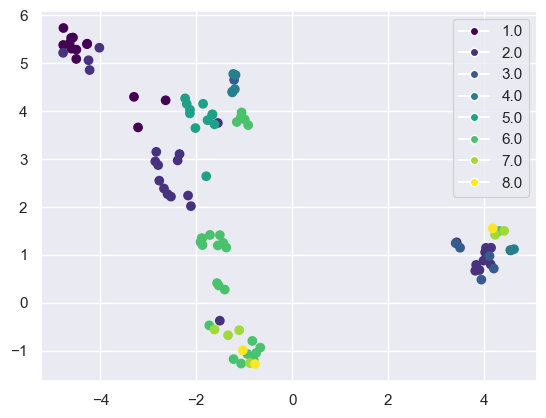

In [71]:
cmap = plt.cm.get_cmap('viridis', len(X_2d['upland_drainage'].unique()))
categories = X_2d['upland_drainage'].unique()
colors = [cmap(i) for i in range(len(categories))]
color_map = dict(zip(categories, colors))

plt.scatter(X_2d[0], X_2d[1], c = X_2d['upland_drainage'].map(color_map))
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c], label=c) for c in categories])
plt.show()